In [191]:
from datasets import load_dataset, Dataset
import pandas as pd
import torch

In [192]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [193]:
def read_excels(file_paths):
    data_frames = [pd.read_excel(file) for file in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

In [194]:
def read_csvs(file_paths):
    data_frames = [pd.read_csv(file) for file in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

In [195]:
read_csv_files = ['dataset_summary_failed_case.csv']

In [196]:
read_files = ['dataset_summary_failed_case.xlsx']

In [197]:
failed_cases_df_initial = read_csvs(read_csv_files)

In [198]:
failed_cases_df = read_excels(read_files)

In [199]:
failed_cases_df.head()

,file_hash,syntactic_error_word,syntactic_error_message,precessed_error_message,syntactic_error_description
0,d3204438087d7d924f50237ca1438a01c5d8bf5e26bb23...,SyntaxError,unmatched ')',unmatched ')',"File ""results/experiment_outputs/20251004T0504..."
1,f131e8b1b384f595ae4976583b055a565560f5f1d70164...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."
2,410c8bffc380e1f887d96db79780392e309662f3b6e135...,SyntaxError,invalid syntax. Perhaps you forgot a comma?,"invalid whitespace in between expression, math...","File ""results/experiment_outputs/20251003T1658..."
3,46e112f054ecc3b819ca39178321dc01d23be5e49c2151...,SyntaxError,too many nested parentheses,too many nested parentheses,"File ""results/experiment_outputs/20251003T0117..."
4,71ddfa42351aae24b5c2bfe98c77117fd09f683ac3da97...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."


In [200]:
failed_cases_df_initial.head()

,file_hash,syntactic_error_word,syntactic_error_message,precessed_error_message,syntactic_error_description
0,d3204438087d7d924f50237ca1438a01c5d8bf5e26bb23...,SyntaxError,unmatched ')',unmatched ')',"File ""results/experiment_outputs/20251004T0504..."
1,f131e8b1b384f595ae4976583b055a565560f5f1d70164...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."
2,410c8bffc380e1f887d96db79780392e309662f3b6e135...,SyntaxError,invalid syntax. Perhaps you forgot a comma?,invalid syntax. perhaps you forgot a comma?,"File ""results/experiment_outputs/20251003T1658..."
3,46e112f054ecc3b819ca39178321dc01d23be5e49c2151...,SyntaxError,too many nested parentheses,too many nested parentheses,"File ""results/experiment_outputs/20251003T0117..."
4,71ddfa42351aae24b5c2bfe98c77117fd09f683ac3da97...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."


In [201]:
failed_cases_df_initial = failed_cases_df_initial[failed_cases_df_initial["precessed_error_message"] != "invalid syntax"]

In [202]:
failed_cases_df_initial = failed_cases_df_initial[failed_cases_df_initial["precessed_error_message"] != "version none is invalid"]
failed_cases_df = failed_cases_df[failed_cases_df["precessed_error_message"] != "version none is invalid"]

In [203]:
failed_cases_df_initial["precessed_error_message"].to_list()

["unmatched ')'",
 "closing parenthesis ']' does not match opening parenthesis '('",
 'invalid syntax. perhaps you forgot a comma?',
 'too many nested parentheses',
 "closing parenthesis ']' does not match opening parenthesis '('",
 'unterminated string literal',
 "closing parenthesis ')' does not match opening parenthesis '{'",
 "'(' was never closed",
 "invalid character '✗'",
 "expected 'except' or 'finally' block",
 'unexpected indent',
 'f-string expression part cannot include a backslash',
 'f-string: invalid syntax',
 'too many nested parentheses',
 'invalid syntax. perhaps you forgot a comma?',
 'cannot assign to literal',
 'unterminated string literal',
 "f-string: single '}' is not allowed",
 "f-string: expecting a valid expression after '{'",
 "f-string: expecting '!', or ':', or '}'",
 'unterminated string literal',
 "f-string: expecting '}'",
 "closing parenthesis ')' does not match opening parenthesis '[' on line 37",
 "'[' was never closed",
 "f-string: expecting a valid

In [204]:
failed_cases_df["precessed_error_message"].to_list()

["unmatched ')'",
 "closing parenthesis ']' does not match opening parenthesis '('",
 'invalid whitespace in between expression, mathematical operands missing',
 'too many nested parentheses',
 "closing parenthesis ']' does not match opening parenthesis '('",
 'code object added inside tuple',
 'unterminated string literal',
 "closing parenthesis ')' does not match opening parenthesis '{'",
 "'(' was never closed",
 "invalid character '✗'",
 "expected 'except' or 'finally' block",
 'unexpected indent',
 'f-string expression part cannot include a backslash',
 "missing closing ']' and ')'",
 'f-string: invalid syntax',
 'except without try block',
 'too many nested parentheses',
 'incomplete in-line ternary operator, bitwise operation on byte object',
 'invalid whitespace in between expression, mathematical operands missing',
 'cannot assign to literal',
 'unterminated string literal',
 "f-string: single '}' is not allowed",
 'two key-value pars inside the dictionary comprehension instea

In [231]:
combined = failed_cases_df_initial["precessed_error_message"].to_list() + failed_cases_df["precessed_error_message"].to_list()

In [232]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [233]:
X = model.encode(combined, normalize_embeddings=True)  # already L2 normalized

In [285]:
kmeans = KMeans(n_clusters=6, n_init=50, random_state=42)
labels = kmeans.fit_predict(X)
score = silhouette_score(X, labels, metric="cosine")

In [286]:
map_of_labels = pd.DataFrame(columns=["error_message", "label"])

In [287]:
for t, lbl in zip(combined, labels):
    new_df = pd.DataFrame([[t, lbl]], columns=["error_message", "label"])
    map_of_labels = pd.concat([map_of_labels, new_df], ignore_index=True)
print("silhouette (cosine):", score)

silhouette (cosine): 0.3810822367668152


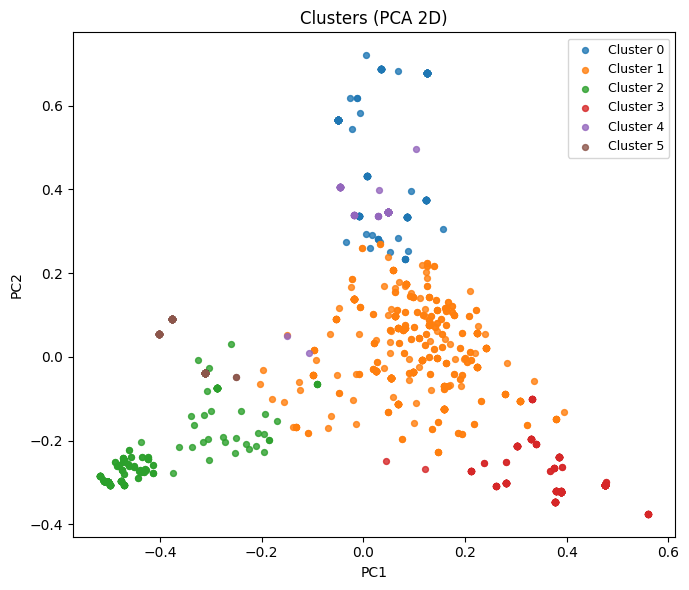

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X)

# Plot
plt.figure(figsize=(7,6))
uniq = np.unique(labels)
for lab in uniq:
    m = labels == lab
    marker = "x" if lab == -1 else "o"
    plt.scatter(XY[m,0], XY[m,1], s=18, alpha=0.8, label=f"Cluster {lab}", marker=marker)

plt.title("Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", fontsize=9, frameon=True)
plt.tight_layout()
plt.show()


In [289]:
map_of_labels.head()

,error_message,label
0,unmatched ')',1
1,closing parenthesis ']' does not match opening...,2
2,invalid syntax. perhaps you forgot a comma?,1
3,too many nested parentheses,2
4,closing parenthesis ']' does not match opening...,2


In [290]:
# Define the output file name
output_filename = "cluster_messages_with_initial.xlsx"

# Use pd.ExcelWriter as a context manager
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    for i in range(6):
        
        # Filter for the current cluster
        selected_cluster = map_of_labels[map_of_labels["label"] == i]
        
        # Define the sheet name
        sheet_name = f"Cluster_{i}"
        
        # Write this cluster's DataFrame to a specific sheet
        selected_cluster.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All clusters saved to {output_filename}")

All clusters saved to cluster_messages_with_initial.xlsx
